# Installations

In [105]:
%%capture
%pip install googletrans==3.1.0a0
%pip install empath
%pip install umls-api
%pip install wordcloud
%pip install mysql-connector-python
%pip install spacy

In [112]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 653.6 kB/s eta 0:00:20
      --------------------------------------- 0.3/12.8 MB 2.7 MB/s eta 0:00:05
     -- ------------------------------------- 0.7/12.8 MB 4.5 MB/s eta 0:00:03
     --- ------------------------------------ 1.2/12.8 MB 5.7 MB/s eta 0:00:03
     ----- ---------------------------------- 1.7/12.8 MB 6.8 MB/s eta 0:00:02
     ------ --------------------------------- 2.2/12.8 MB 7.5 MB/s eta 0:00:02
     -------- ------------------------------- 2.8/12.8 MB 8.0 MB/s eta 0:00:02
     ---------- ----------------------------- 3.3/12.8 MB 8.5 MB/s eta 0:00:02
     ------------ --------------------------- 3.9/12.8 MB 9.1 MB/s eta 0:00:01
     ------------- -------------------------- 4.4/12.8 MB 9.3 MB/s eta 0:00:01
     --------------- ------------------------ 4.9/12.8 MB 9.5 MB/

# Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from googletrans import Translator
import time
from tqdm import tqdm
import numpy as np
from scipy.stats import skew, kurtosis
from wordcloud import WordCloud, STOPWORDS
import empath
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import umls_api
import string
import requests
import mysql.connector
import spacy
import re

In [4]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fahad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fahad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Load

In [15]:
folder = "D:/OULU/SEM_1/Period_1/NLP/Project/Nlp_Project/"

df = pd.read_csv("syoparap_merkinta_otsikko.csv", parse_dates=['insert_date_utc'], dayfirst=True)
df_with_narratives = pd.read_csv(folder + 'translated_data.csv', parse_dates=['insert_date_utc'], dayfirst=True)
df_with_medical_terms = pd.read_csv(folder + 'translated_data_with_medical_terms.csv', parse_dates=['insert_date_utc'], dayfirst=True)
df_recommendations_with_medical_terms = pd.read_csv(folder + 'recommendations_with_medical_terms.csv')
category_df = pd.read_csv(folder + 'empath_categories_on_translated_narratives.csv')
category_df_recommendations = pd.read_csv(folder + 'empath_categories_on_recommendations.csv')


In [8]:
semantic_types_treeNumber = ['A1.1.2','A1.1.3.2','A1.1.4',
                  'A1.2.1','A1.2.2.1','A1.2.2.2','A1.2.3.1','A1.2.3.2','A1.2.3.3','A1.2.3.4','A1.2.3.5',
                  'A1.3.3',
                  'A1.4.1.1.1.1','A1.4.1.1.2','A1.4.1.1.3.2','A1.4.1.1.3.3','A1.4.1.1.3.4','A1.4.1.1.3.5','A1.4.1.1.3.6','A1.4.1.1.4','A1.4.1.1.5','A1.4.1.2.1.5','A1.4.1.2.1.7','A1.4.1.2.2','A1.4.1.2.3','A1.4.2','A1.4.3',
                  'A2.1.4.1','A2.1.5.1','A2.1.5.2','A2.1.5.3','A2.1.5.3.1','A2.1.5.3.2','A2.1.5.3.3',
                  'A2.2.1','A2.2.2',
                  'A2.3','A2.3.1',
                  'B1.1.1','B1.1.2',
                  'B1.2',
                  'B1.3.1','B1.3.1.1','B1.3.1.2','B1.3.1.3','B1.3.2.1',
                  'B2.2.1.1','B2.2.1.1.1','B2.2.1.1.1.1','B2.2.1.1.2','B2.2.1.1.3','B2.2.1.1.4','B2.2.1.1.4.1',
                  'B2.2.1.2','B2.2.1.2.1','B2.2.1.2.1.1','B2.2.1.2.1.2','B2.2.1.2.2','B2.2.1.2.3',
                  'B2.3',
                  'R3.1.2',
                  'R5.6']

semantic_types_tui = [  'T007','T004','T005',
                        'T018','T019','T020','T023','T024','T025','T026','T028',
                        'T200',
                        'T121','T122','T125','T126','T127','T129','T192','T130','T131','T114','T116','T197','T196','T031','T168',
                        'T022','T030','T029','T085','T086','T087','T088',
                        'T034','T184',
                        'T032','T201',
                        'T054','T055',
                        'T056',
                        'T058','T059','T060','T061','T063',
                        'T039','T040','T041','T042','T043','T044','T045',
                        'T046','T047','T048','T191','T049','T050',
                        'T037',
                        'T154',
                        'T163']

Run this, if you have Recommendation Verbs saved

# overview

In [9]:
# Basic Information
rows, columns = df.shape
data_types = df.dtypes
non_null_counts = df.count()
column_names = df.columns
summary_stats = df.describe()
unique_values = df['mid'].unique()
value_counts = df['mid'].value_counts()
missing_values = df.isnull().sum()
data_preview = df.head()

# # Export Metadata to CSV
# data_types.to_csv(folder + 'metadata.csv', header=['Data Types'])
# non_null_counts.to_csv(folder + 'metadata.csv', mode='a', header=['Non-null Counts'])
# summary_stats.to_csv(folder + 'metadata.csv', mode='a')
# missing_values.to_csv(folder + 'metadata.csv', mode='a', header=['Missing Values'])

# Print the results
print("Number of rows and columns:", rows, columns)
print("Data types of columns:")
print(data_types)
print("Number of non-null values in each column:")
print(non_null_counts)
print("Column names:", column_names)
print("Summary statistics:")
print(summary_stats)
# print("Unique values in 'mid':")
# print(unique_values)
# print("Value counts in 'mid':")
# print(value_counts)
print("Missing values in each column:")
print(missing_values)
print("Data preview (first 5 rows):")
print(data_preview)

# Print a confirmation message
print("Metadata has been exported to metadata.csv")

Number of rows and columns: 1293359 7
Data types of columns:
mid                          int64
otsikko_oid                 object
jarjestys                    int64
vaihe                       object
otsikkokoodi                object
narratiiviteksti            object
insert_date_utc     datetime64[ns]
dtype: object
Number of non-null values in each column:
mid                 1293359
otsikko_oid         1293359
jarjestys           1293359
vaihe               1293359
otsikkokoodi        1293359
narratiiviteksti      24460
insert_date_utc      118440
dtype: int64
Column names: Index(['mid', 'otsikko_oid', 'jarjestys', 'vaihe', 'otsikkokoodi',
       'narratiiviteksti', 'insert_date_utc'],
      dtype='object')
Summary statistics:
                mid     jarjestys                insert_date_utc
count  1.293359e+06  1.293359e+06                         118440
mean   4.820086e+06  3.072849e+00  2017-12-08 17:10:15.234659072
min    4.000000e+00  0.000000e+00            2017-11-07 05:03:12

# Bar Graph on Proportion of Patients with Narrative Text

narrative_present: False    1269007
True       24352
Name: narrative_present, dtype: int64


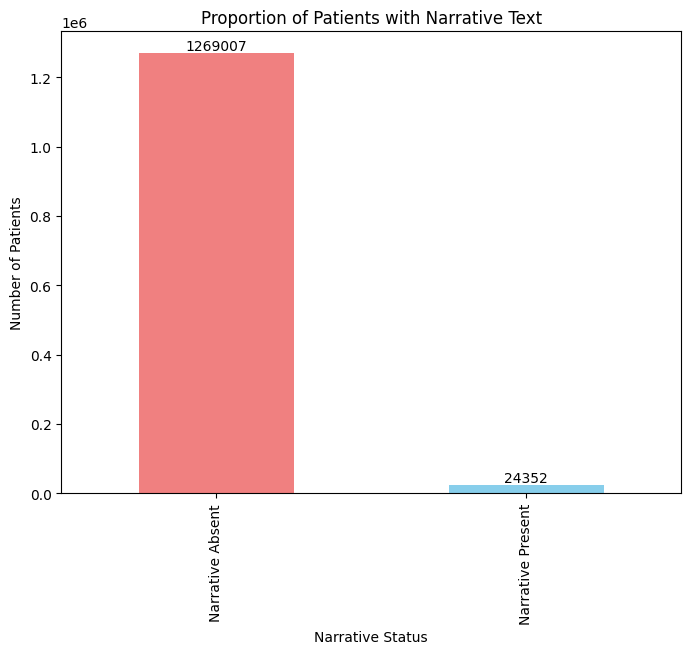

In [ ]:
df['narrative_present'] = df['narratiiviteksti'].apply(lambda x: isinstance(x, str) and x.strip() != '').astype(bool)
counts = df['narrative_present'].value_counts()

print(f"narrative_present: {counts}")

# Plot a histogram with labeled bars
plt.figure(figsize=(8, 6))
ax = counts.plot(kind='bar', color=['lightcoral', 'skyblue'])
plt.title('Proportion of Patients with Narrative Text')
plt.xticks([0, 1], ['Narrative Absent', 'Narrative Present'])
plt.xlabel('Narrative Status')
plt.ylabel('Number of Patients')

# Add labels to the bars
for i in range(len(counts)):
    plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom')
plt.show()

# Translation (--Very Time Cosuming-- Only run, if you dont have a translated version.)

In [ ]:
df_with_narratives = df[df['narratiiviteksti'].str.strip() != '']  # Excludes empty strings
df_with_narratives = df_with_narratives[df_with_narratives['narratiiviteksti'].notna()]  # EXclude rows with NaN values

# Initialize Google Translate API
translator = Translator()

# Define a function to translate text and handle exceptions
def translate_text(text):
    try:
        translation = translator.translate(text, src='fi', dest='en')
        return translation.text
    except Exception as e:
        print(f"Translation error: {e}, on text: {text}")
        return None


# Apply translation with a delay and store the results in a new column
translation_results = []
print(f"total_rows: {df_with_narratives['narratiiviteksti'].shape[0]}")
for i, text in tqdm(enumerate(df_with_narratives['narratiiviteksti'])):
    translation = translate_text(text)
    translation_results.append(translation)
    
    time.sleep(0.2) # Add a delay of 0.2 seconds between translations because currently Google Translate API allows 5 calls/second, caps it at 200k a day

df_with_narratives['translated_narrative'] = translation_results

df_with_narratives.to_csv(folder + 'translated_data.csv', index=False)
print("Translation and data saving complete.")

total_rows: 24352


24352it [1:39:34,  4.08it/s]


Translation and data saving complete.


# Stats

In [12]:
# Assuming you have a DataFrame df with a 'translated_narrative' column
narratives = df_with_narratives['translated_narrative'].dropna()  # Remove any NaN values

# Function to count words in a text
def count_words(text):
    words = text.split()
    return len(words)

# Calculate the number of words in each narrative
word_counts = narratives.apply(count_words)

# Calculate the mean, standard deviation, skewness, and kurtosis
mean_word_count = word_counts.mean()
std_word_count = word_counts.std()
skewness = skew(word_counts)
kurt = kurtosis(word_counts)

# Output the results
print(f"Mean Word Count: {mean_word_count:.2f}")
print(f"Standard Deviation of Word Count: {std_word_count:.2f}")
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurt:.2f}")


Mean Word Count: 63.34
Standard Deviation of Word Count: 79.69
Skewness: 3.19
Kurtosis: 17.28


# Word Cloud

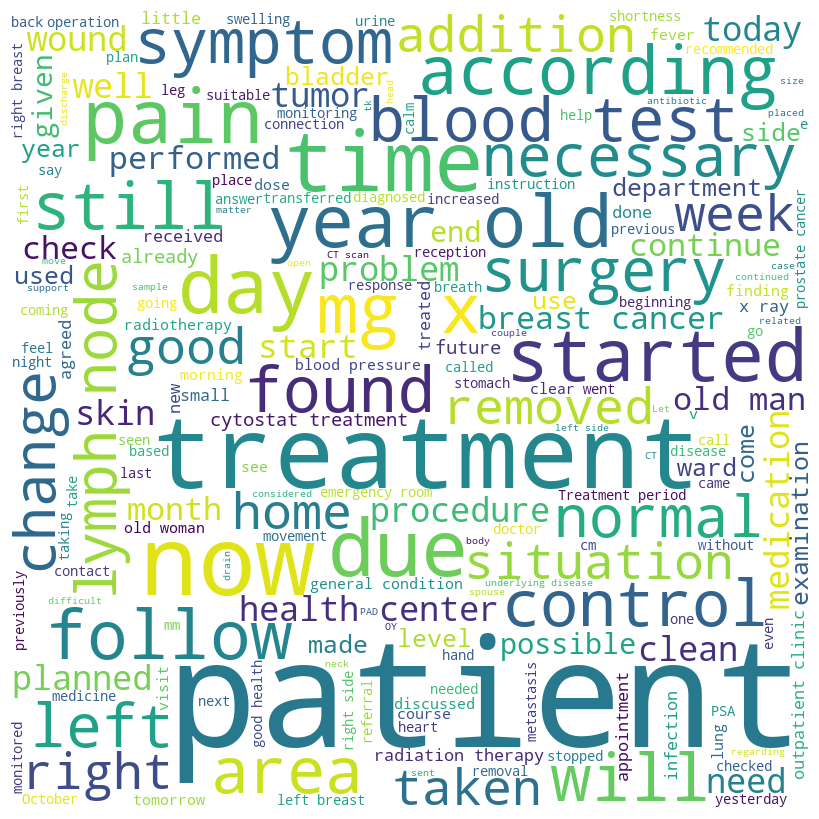

In [14]:
# Combine all the translated narratives into a single string
narratives_text = ' '.join(df_with_narratives['translated_narrative'].dropna())

# Create a WordCloud object
wordcloud = WordCloud(
    background_color='white',
    stopwords=set(STOPWORDS),  # You can add more stopwords if needed
    width=800,
    height=800,
    min_font_size=10
).generate(narratives_text)

# Plot the WordCloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

# Show the WordCloud
plt.show()


# Bar Graph of Word Usage Categories (Empath Categories Generation)

only run, if you dont have empath categories saved already

In [7]:
# Initialize the Empath analyzer
analyzer = empath.Empath()

# Assuming you have a DataFrame with a 'translated_narrative' column
narratives = df_with_narratives['translated_narrative'].dropna()

category_scores = []

# Analyze each narrative and store the category scores
for narrative in tqdm(narratives):
    category_score = analyzer.analyze(narrative, normalize=True)
    category_scores.append(category_score)

# Create a DataFrame from the list of category scores
category_df = pd.DataFrame(category_scores)
print(f"category_df: {category_df}")
# Calculate the proportions for each category

category_df.to_csv(folder + 'empath_categories_on_translated_narratives.csv', index=False)

100%|██████████| 24352/24352 [03:15<00:00, 124.33it/s]


category_df:            help    office     dance     money   wedding  domestic_work  \
0      0.000000  0.000000  0.000000  0.000000  0.000000       0.000000   
1      0.014286  0.000000  0.000000  0.000000  0.000000       0.000000   
2      0.000000  0.000000  0.000000  0.000000  0.000000       0.000000   
3      0.000000  0.000000  0.000000  0.000000  0.000000       0.000000   
4      0.000000  0.000000  0.000000  0.000000  0.000000       0.000000   
...         ...       ...       ...       ...       ...            ...   
24347  0.000000  0.000000  0.000000  0.000000  0.000000       0.000000   
24348  0.019694  0.006565  0.002188  0.002188  0.004376       0.000000   
24349  0.000000  0.000000  0.000000  0.000000  0.000000       0.117647   
24350  0.000000  0.000000  0.000000  0.000000  0.000000       0.000000   
24351  0.031250  0.000000  0.000000  0.000000  0.000000       0.031250   

          sleep  medical_emergency  cold      hate  ...    weapon  children  \
0      0.000000    

display empath categories from saved categories

category_proportions: help                0.012053
office              0.003438
dance               0.000445
money               0.000880
wedding             0.002690
                      ...   
contentment         0.000634
writing             0.001786
rural               0.000090
positive_emotion    0.002198
musical             0.000374
Length: 194, dtype: float64


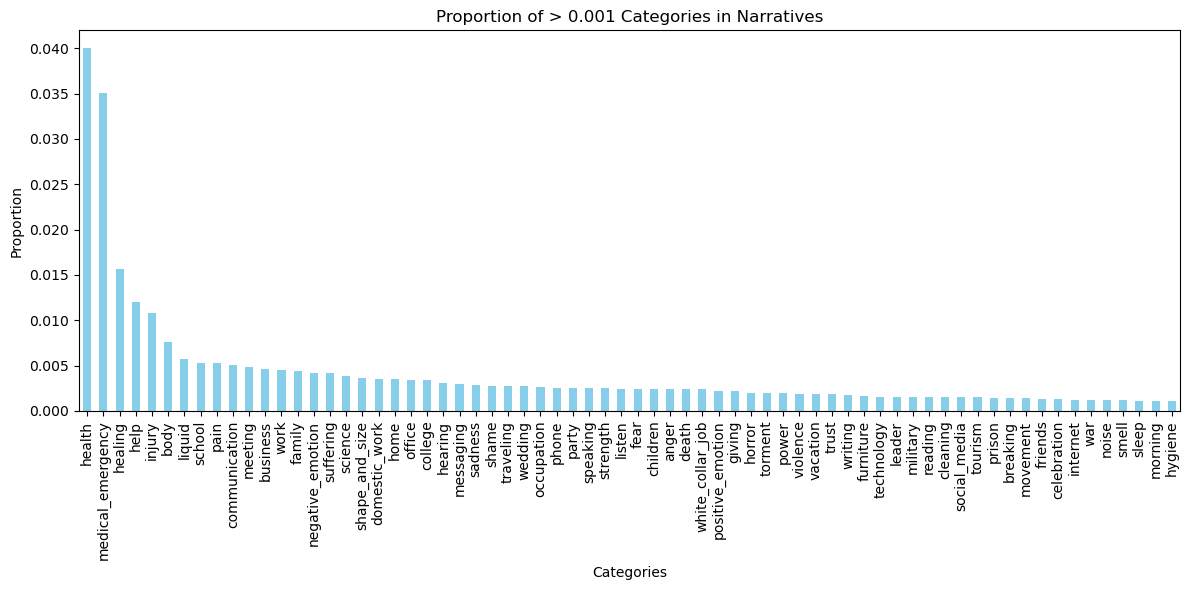

In [8]:
category_proportions = category_df.mean()
print(f"category_proportions: {category_proportions}")
filtered_categories = category_proportions[category_proportions > 0.001]

# Plot the histogram
plt.figure(figsize=(12, 6))
filtered_categories.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Proportion of > 0.001 Categories in Narratives')
plt.xlabel('Categories')
plt.ylabel('Proportion')
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()


# Stats of Medical technical terminology employed by the doctors

Way# 1: Matching technical terminologies through UMLS API

In [ ]:
apikey = "331c92a4-d3b7-4c97-a983-2f388b08f863"
base = 'https://uts-ws.nlm.nih.gov'

def match_word(word):
    query_word = base + "/rest/search/current"
    page = 0

    try:
        while True:
            page += 1
            # query words exact matching with concepts
            query = {'string':word,'apiKey':apikey, 'pageNumber':page, 'searchType':'exact'}
            word_match_resp = requests.get(query_word, params=query)
            word_match_resp.raise_for_status()
            word_match_resp.encoding = 'utf-8'
            word_match_resp_json  = word_match_resp.json()
            matching_concepts = (([word_match_resp_json['result']])[0])['results']

            if len(matching_concepts) == 0:
                return False
            # else:
                # print(f"matching_concepts: {matching_concepts}")

            for each_concept in matching_concepts:
                cui = each_concept['ui']
                # print('\n')
                # for key in each_concept:
                    # print(f"{key}: {each_concept[key]}")

                # query to find tui by cui
                query_by_cui = base + '/content/current/CUI/'
                cui_resp = requests.get(query_by_cui + cui, params={'apiKey':apikey})
                cui_resp_json = cui_resp.json()
                results = cui_resp_json['result']
                # print('UI: ' + results['ui'] + '\n' + 'Name: ' + results['name'] + '\n' + 'Semantic Type: ' + results['semanticTypes'][0]['name'] + '\n' + 'Semantic Type URI: ' + results['semanticTypes'][0]['uri'] + '\n' + '\n')

                TUI = results['semanticTypes'][0]['uri'].split('/')[-1]
                # print(f"TUI: {TUI}")

                # query to check semantic similarity of medical branches of umls tree by tui
                tui_resp = umls_api.API(api_key="331c92a4-d3b7-4c97-a983-2f388b08f863").get_tui(TUI)
                treeNumber = tui_resp['result']['treeNumber']
                if treeNumber in semantic_types_treeNumber:
                    # print('\n')
                    # print('UI: ' + results['ui'] + '\n' + 'Name: ' + results['name'] + '\n' + 'Semantic Type: ' + results['semanticTypes'][0]['name'] + '\n' + 'Semantic Type URI: ' + results['semanticTypes'][0]['uri'] + '\n' + '\n')
                    # print(f"TUI: {TUI}")
                    # print(f"name: {tui_resp['result']['name']}")
                    # print(f"treeNumber: {treeNumber}")
                    return True
                # else:
                #     print("not a medical term")
                # print(tui_resp)
                # for field in tui_resp["result"]:
                #     print(f"{field}: {tui_resp['result'][field]}")

    except Exception as except_error:
        print(except_error)

    return False

# Define a function to search for UMLS terms in text
def search_medical_terms(text):

    medical_terms = []
    temp_terms = []

    # Tokenize and preprocess the text
    text = text.lower()
    words = word_tokenize(text)
    words = [word for word in words if word not in string.punctuation]
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    medical_term_count = 0

    # Search for UMLS terms in the text
    for word in words:
        term_matches = match_word(word)
        if term_matches:
            medical_term_count += 1
            temp_terms.append(word)

    print(f"medical_term_count: {medical_term_count}")
    medical_terms.append(temp_terms)

    return medical_terms, medical_term_count

# Apply the search function to each narrative text
df_with_narratives['medical_term_count'] = df_with_narratives['translated_narrative'].apply(search_medical_terms)
# df_temp = df_with_narratives.head(100)

result = df_with_narratives['translated_narrative'].apply(search_medical_terms)
df_with_narratives['medical_terms'] = result.apply(lambda x: x[0])
df_with_narratives['medical_term_count'] = result.apply(lambda x: x[1])

print(df_with_narratives[['translated_narrative', 'medical_terms', 'medical_term_count']])

# Calculate statistics
mean_medical_terms = df_with_narratives['medical_term_count'].mean()
std_medical_terms = df_with_narratives['medical_term_count'].std()
skewness_medical_terms = df_with_narratives['medical_term_count'].skew()
kurtosis_medical_terms = df_with_narratives['medical_term_count'].kurtosis()

# Output the results
print(f"Mean Number of Medical Terms: {mean_medical_terms}")
print(f"Standard Deviation of Medical Terms: {std_medical_terms}")
print(f"Skewness of Medical Terms: {skewness_medical_terms}")
print(f"Kurtosis of Medical Terms: {kurtosis_medical_terms}")

df_with_narratives.to_csv(folder + 'translated_data_with_medical_terms.csv', index=False)

Way# 2: Matching technical terminologies through localhost Database Query

Create Localhost Database Connection and cursor to query

In [ ]:
def create_connection():
    db_config = {
        "host": "localhost",
        "user": "root",
        "password": "12545",
        "database": "umls_2022aa",
    }

    try:
        # Establish a connection
        conn = mysql.connector.connect(**db_config)
        # print(f"conn: {conn}")

        # Create a cursor
        cursor = conn.cursor()
        # print(f"cursor: {cursor}")

    except mysql.connector.Error as err:
        print(f"Error: {err}")
    
    return cursor, conn

def close_connection(cursor, conn):
    cursor.close()
    conn.close()

In [ ]:
def match_word(cursor, word):

    try:
        sql_query = """
        SELECT DISTINCT b.cui, b.str, a.tui
        FROM mrsty a
        JOIN mrconso b ON a.cui = b.cui
        WHERE b.str = %s
        AND a.tui IN ({})""".format(', '.join(['%s'] * len(semantic_types_tui)))

        # Parameters for the SQL query
        query_parameters = [word] + semantic_types_tui

        # Execute the query with parameters
        cursor.execute(sql_query, query_parameters)

        # Fetch and print the results
        results = cursor.fetchall()
        # print(f"results: {results}")
        # print(f"results length: {len(results)}")
        # for row in results:
        #     print(row)
        
        if len(results) > 0:
            return True
        else:
            return False

    except mysql.connector.Error as err:
        print(f"Error: {err}")
        return False
    


# Define a function to search for UMLS terms in text
def search_medical_terms(text):

    cursor, conn = create_connection()

    medical_terms = []
    temp_terms = []

    # Tokenize and preprocess the text
    text = text.lower()
    text = ' '.join(text.split())
    text = text.replace('\n', ' ')
    words = word_tokenize(text)
    words = [word for word in words if word not in string.punctuation]
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    words = [word for word in words if not word.isnumeric()]

    # Initialize a variable to count medical terms
    medical_term_count = 0

    # Search for UMLS terms in the text
    for word in words:
        term_matches = match_word(cursor, word)
        if term_matches:
            medical_term_count += 1
            temp_terms.append(word)
        # else:
        #     print(f'term: {word} not found')

    medical_terms.append(temp_terms)

    close_connection(cursor, conn)

    return medical_terms, medical_term_count

# search_medical_terms('xyz fever headache')
# Apply the search function to each narrative text
# df_temp = df_with_narratives.head()
# df_with_narratives['medical_term_count'] = df_with_narratives['translated_narrative'].apply(search_medical_terms)

tqdm.pandas()

# df_temp = df_with_narratives.head(100)
result = df_with_narratives['translated_narrative'].progress_apply(search_medical_terms)
df_with_narratives['medical_terms'] = result.apply(lambda x: x[0])
df_with_narratives['medical_term_count'] = result.apply(lambda x: x[1])

# Calculate statistics
mean_medical_terms = df_with_narratives['medical_term_count'].mean()
std_medical_terms = df_with_narratives['medical_term_count'].std()
skewness_medical_terms = df_with_narratives['medical_term_count'].skew()
kurtosis_medical_terms = df_with_narratives['medical_term_count'].kurtosis()

# Output the results
print(f"Mean Number of Medical Terms: {mean_medical_terms}")
print(f"Standard Deviation of Medical Terms: {std_medical_terms}")
print(f"Skewness of Medical Terms: {skewness_medical_terms}")
print(f"Kurtosis of Medical Terms: {kurtosis_medical_terms}")

df_with_narratives.to_csv(folder + 'translated_data_with_medical_terms.csv', index=False)

If you already have the data with medical terms, then run this

Mean Number of Medical Terms: 17.027882720105126
Standard Deviation of Medical Terms: 20.73176124948086
Skewness of Medical Terms: 2.93168079278094
Kurtosis of Medical Terms: 13.91826607269128


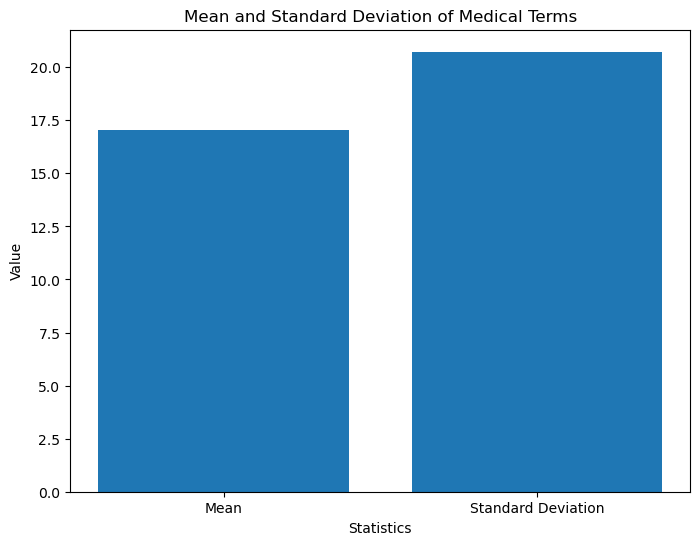

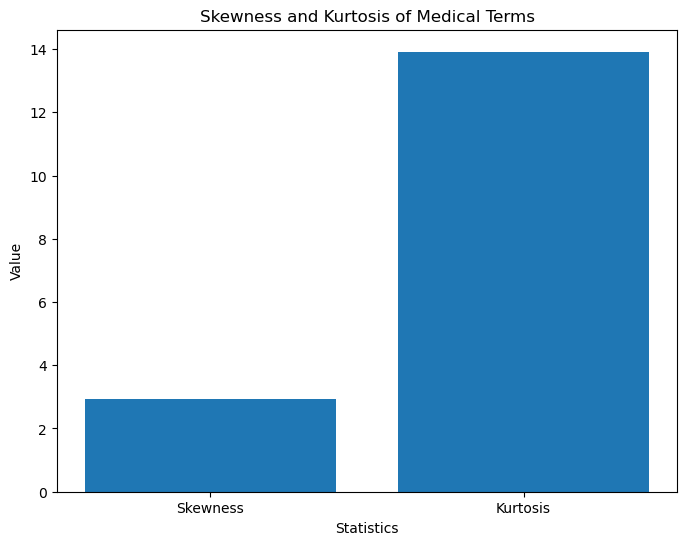

In [20]:
# Calculate statistics
mean_medical_terms = df_with_medical_terms['medical_term_count'].mean()
std_medical_terms = df_with_medical_terms['medical_term_count'].std()
skewness_medical_terms = df_with_medical_terms['medical_term_count'].skew()
kurtosis_medical_terms = df_with_medical_terms['medical_term_count'].kurtosis()

# Output the results
print(f"Mean Number of Medical Terms: {mean_medical_terms}")
print(f"Standard Deviation of Medical Terms: {std_medical_terms}")
print(f"Skewness of Medical Terms: {skewness_medical_terms}")
print(f"Kurtosis of Medical Terms: {kurtosis_medical_terms}")

# Create a bar plot for mean and standard deviation
plt.figure(figsize=(8, 6))
plt.bar(['Mean', 'Standard Deviation'], [mean_medical_terms, std_medical_terms])
plt.xlabel('Statistics')
plt.ylabel('Value')
plt.title('Mean and Standard Deviation of Medical Terms')
plt.show()

# Create a bar plot for skewness and kurtosis
plt.figure(figsize=(8, 6))
plt.bar(['Skewness', 'Kurtosis'], [skewness_medical_terms, kurtosis_medical_terms])
plt.xlabel('Statistics')
plt.ylabel('Value')
plt.title('Skewness and Kurtosis of Medical Terms')
plt.show()

# Correlation Analysis: Medical Vocabulary and Word Count in Narrative Texts

100%|██████████| 22/22 [00:01<00:00, 11.16it/s]


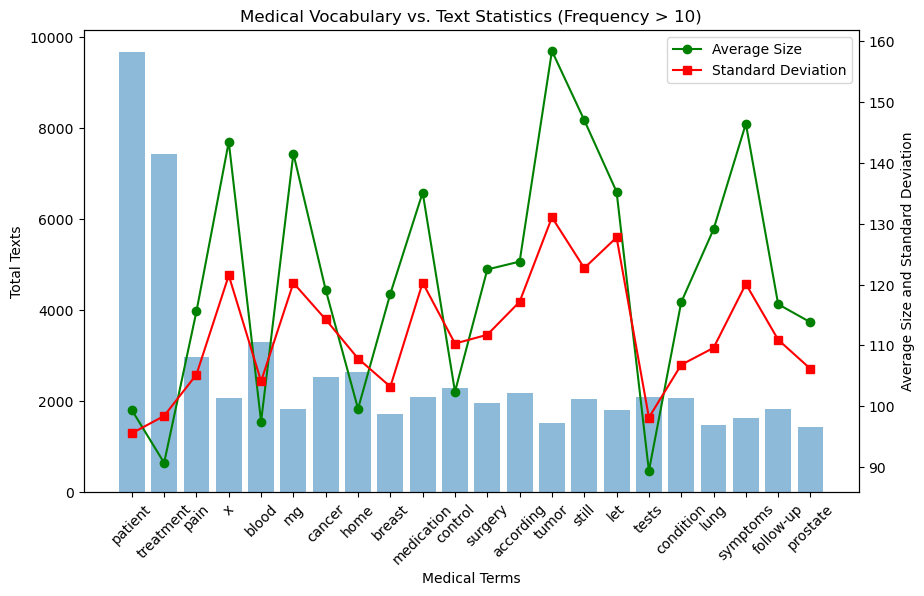

In [103]:
df_with_medical_terms['medical_terms'] = df_with_medical_terms['medical_terms'].apply(eval) # only run, if you have just loaded the dataframe from csv, cuz it will be in string format
medical_terms = df_with_medical_terms['medical_terms'].apply(lambda x: x[0]).explode()

# Count the frequency of each medical term
medical_terms_frequency = medical_terms.value_counts().to_dict()

# Select the most frequent medical terms and their counts
top_medical_terms = list(medical_terms_frequency.keys())

# Filter medical terms with a frequency greater than 10
filtered_top_terms = [term for term in top_medical_terms if medical_terms_frequency[term] > 2000]

# Create a DataFrame for the filtered terms
filtered_data = df_with_medical_terms[df_with_medical_terms['medical_terms'].apply(lambda x: any(term in x[0] for term in filtered_top_terms))]

# Calculate total texts, average size, and standard deviation for each filtered term
filtered_total_texts = []
filtered_average_sizes = []
filtered_std_deviations = []

for term in tqdm(filtered_top_terms):
    term_texts = filtered_data[filtered_data['medical_terms'].apply(lambda x: term in x[0])]
    term_texts1 = filtered_data[filtered_data['medical_terms'].apply(lambda x: term in x)]

    filtered_total_texts.append(len(term_texts))
    filtered_average_sizes.append(term_texts['translated_narrative'].str.split().apply(len).mean())
    filtered_std_deviations.append(term_texts['translated_narrative'].str.split().apply(len).std())

# Create the histogram for filtered terms
plt.figure(figsize=(10, 6))

# Plot total texts
plt.bar(filtered_top_terms, filtered_total_texts, alpha=0.5, label='Total Texts')
plt.xlabel('Medical Terms')
plt.ylabel('Total Texts')
plt.xticks(rotation=45)

# Create a second y-axis for average size and standard deviation
ax2 = plt.twinx()

# Plot average size and standard deviation
ax2.plot(filtered_top_terms, filtered_average_sizes, 'g', marker='o', label='Average Size')
ax2.plot(filtered_top_terms, filtered_std_deviations, 'r', marker='s', label='Standard Deviation')
ax2.set_ylabel('Average Size and Standard Deviation')

# Customize the plot
plt.title('Medical Vocabulary vs. Text Statistics (Frequency > 2000)')
plt.legend(loc='upper right')

# Show the plot
plt.show()


# Recommendation

Run this, if you dont have RecommmendationsVerbs Saved

In [62]:
# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Define a list of POS (part-of-speech) tags that represent verbs for recommendations
recommendation_verbs = ["VB", "VBP", "VBZ"]

# Create an empty list to store the recommendation verbs
recommendation_verbs_set = set()

# Assuming 'translated_narrative' is the column containing narrative text
for text in tqdm(df_with_medical_terms['translated_narrative']):

    text = text.lower()
    text = re.sub(r"'", "", text)
    text = ' '.join(text.split())
    text = text.replace('\n', ' ')
    words = word_tokenize(text)
    words = [word for word in words if word not in string.punctuation]
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    words = [word for word in words if not word.isnumeric()]

    doc = nlp(text)
    # Extract verbs related to recommendations
    for token in doc:
        if token.tag_ in recommendation_verbs:
            recommendation_verbs_set.add(token.text)

print(f"Recommendation Verbs: {recommendation_verbs_set}")

# Save the extracted recommendation verbs to a text file
with open(folder + "recommendation_verbs.txt", "w") as file:
    for verb in recommendation_verbs_set:
        file.write(verb + "\n")

print("Recommendation verbs have been saved to recommendation_verbs.txt.")


100%|██████████| 24352/24352 [04:54<00:00, 82.56it/s] 


Recommendation Verbs: {'disturb', 'stiffen', 'like', 'weight', 'rituximab', 'click', 'thrombosis', 'sponge', 'wheeze', 'doubt', 'diabetes', '\u200b\u200bfvc', 'morphin', 'slides', 'mother', 'try', 'vinorelbine', 'mature', 'lobe', 'vericare', 'hypoglycemia', 'conducts', 'grows', 'warm', 'hinder', 'primperan', 'administers', 'pay', 'euthyroid', 'stenose', 'profamid', 'kbv02', 'process', 'hear', '\u200b\u200bin', 'kaks', 'duodecims', 'suck', 'interfere', 'cannulae', 'secretes', 'appear', 'tingle', 'carelink', 'hypopharyngeal', 'irritate', 'focuses', 'spends', 'innovair', 'gradus', 'visualize', 'states', 'experiences', 'lobes', 'returns', 'afficitate', 'saturate', 'tries', 'watch', 'ablate', 'contains', 'impedances', 'undersigneds', 'tends', 'originate', 'rs230', 'spare', 'recover', 'stitches', 'matters', 'endoscope', 'salvage', '\u200b\u200bcorrespond', 'prostate', 'discharges', 'sores', 'crush', 'drains', 'dries', 'seep', 'meropenem', 'leaves', 'pts', 'growth', 'plastikakir', 'opt', 'int

Run this, if you have Recommendation Verbs saved

In [4]:
# Create an empty set to store the recommendation verbs
recommendation_verbs_set = set()

# Load the recommendation verbs from the file
with open(folder + "recommendation_verbs.txt", "r") as file:
    for line in file:
        recommendation_verbs_set.add(line.strip())

print("Recommendation verbs have been loaded.")
print(f"Recommendation Verbs: {recommendation_verbs_set}")

Recommendation verbs have been loaded.
Recommendation Verbs: {'disturb', 'bun', 'Rise', 'stiffen', 'like', 'weight', 'rituximab', 'Test', 'wheeze', 'thrombosis', 'sponge', 'click', 'doubt', 'diabetes', 'slides', 'try', 'vinorelbine', 'mature', 'lobe', 'Reschedule', 'hypoglycemia', 'conducts', 'grows', 'warm', 'hinder', 'administers', 'pay', 'euthyroid', 'stenose', 'process', 'hear', '\u200b\u200bin', 'suck', 'secretes', 'interfere', 'cannulae', 'appear', 'tingle', 'hypopharyngeal', 'irritate', 'focuses', 'spends', 'gradus', 'visualize', 'states', 'experiences', 'lobes', 'returns', 'afficitate', 'saturate', 'tries', 'watch', 'ablate', 'contains', 'spare', 'impedances', 'tends', 'originate', 'Curve', 'rs230', 'recover', 'Repeat', 'stitches', 'matters', 'salvage', '\u200b\u200bcorrespond', 'prostate', 'Move', 'crush', 'discharges', 'sores', 'drains', 'Yt', 'Ion', 'dries', 'seep', 'meropenem', 'leaves', 'growth', 'plastikakir', 'interferes', 'Avoid', 'Estimate', 'register', 'folate', 'prog

Run this, if you dont have recommendations_with_medical_terms Saved

In [69]:
# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Define empty lists to store the extracted recommendations and medical terms
recommendations = []
medical_terms = []

len_df_with_medical_terms = len(df_with_medical_terms['medical_terms'][0][0])
print(f"len_df_with_medical_terms: {len_df_with_medical_terms}")
if len_df_with_medical_terms < 2:
    df_with_medical_terms['medical_terms'] = df_with_medical_terms['medical_terms'].apply(eval)

# df_temp2 = df_with_medical_terms.head()
# Assuming 'translated_narrative' is the column containing narrative text
for text, terms in tqdm(zip(df_with_medical_terms['translated_narrative'], df_with_medical_terms['medical_terms'])):
    # Process the text with spaCy
    doc = nlp(text)
    
    # Extract sentences containing keywords and their associated terms
    sentences_with_terms = []
    for sentence in doc.sents:
        
        text = sentence.text
        text = text.lower()
        text = re.sub(r"'", "", text)
        text = ' '.join(text.split())
        text = text.replace('\n', ' ')
        words = word_tokenize(text)
        words = [word for word in words if word not in string.punctuation]
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]
        words = [word for word in words if not word.isnumeric()]

        for word in words:
            if word in recommendation_verbs_set:
                # Check if each term exists in the recommendation and add only matched terms
                matching_terms = [term for term in terms[0] if term in sentence.text]
                if matching_terms:
                    sentences_with_terms.append({"Recommendation": sentence.text, "Medical Terms": matching_terms})
                    break
    
    # Extend the recommendations and medical_terms lists
    if sentences_with_terms:
        for item in sentences_with_terms:
            recommendations.append(item["Recommendation"])
            medical_terms.append(item["Medical Terms"])

# Create a DataFrame to store recommendations and associated medical terms
recommendations_df = pd.DataFrame({"Recommendations": recommendations, "Medical Terms": medical_terms})

# Save the DataFrame to a CSV file
recommendations_df.to_csv("recommendations_with_medical_terms.csv", index=False)

# Print a sample of the saved data
print(recommendations_df.head())


len_df_with_medical_terms: 18


24352it [06:07, 66.33it/s] 


                                     Recommendations  \
0  Abdomen soft and compliant with palps, no unus...   
1  No palpable lymph nodes in the neck, clavicles...   
2                       Surgery area and scar clean.   
3   Palpitations in the left breast are not unusual.   
4  Let's check the liver values ​​in about a week...   

                                       Medical Terms  
0                [soft, compliant, liver, rib, cage]  
1           [lymph, nodes, neck, clavicles, armpits]  
2                                             [scar]  
3                                           [breast]  
4  [liver, call, patient, abdominal, ultrasound, ...  


WordCloud for Recommendations

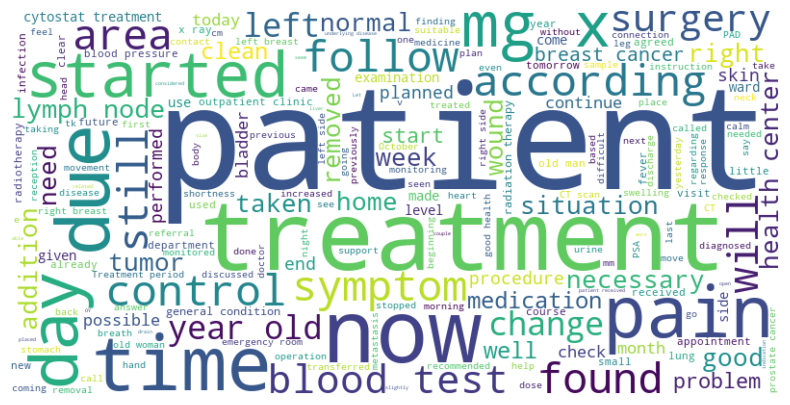

In [75]:
recommendations_string = ' '.join(df_recommendations_with_medical_terms['Recommendations'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(recommendations_string)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


Proportion of the medical vocabulary used in recommendation

Total Recommendations: 8347346
Recommendations with Medical Vocabulary: 100539
Proportion of Medical Vocabulary in Recommendations: 1.20%


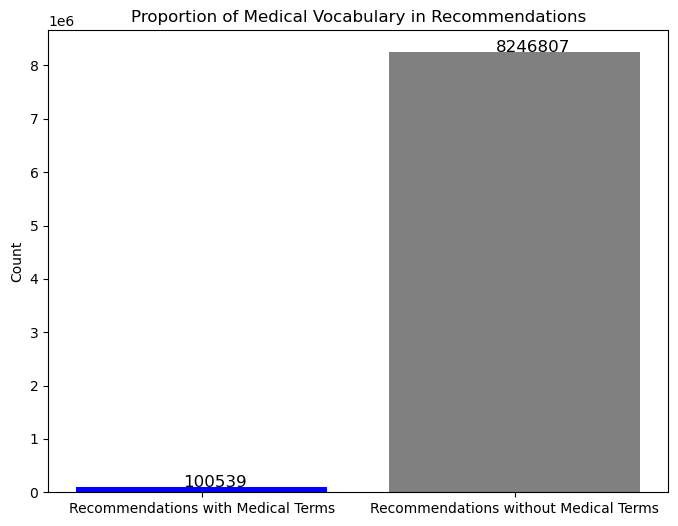

In [10]:
# df_em = df_recommendations_with_medical_terms.head()

# Extract recommendations and medical terms from the DataFrame
recommendations = df_recommendations_with_medical_terms['Recommendations']
medical_terms = df_recommendations_with_medical_terms['Medical Terms']

# Initialize a counter for recommendations with medical terms
recommendations_with_medical_count = 0
total_recommendations = 0

# Iterate through each recommendation and check for the presence of medical terms
for rec, terms in zip(recommendations, medical_terms):
    total_recommendations += len(rec)
    if any(term in rec for term in terms):
        recommendations_with_medical_count += 1

# Calculate the proportion
# total_recommendations = len(recommendations)
proportion = (recommendations_with_medical_count / total_recommendations) * 100

# Display the results
print(f"Total Recommendations: {total_recommendations}")
print(f"Recommendations with Medical Vocabulary: {recommendations_with_medical_count}")
print(f"Proportion of Medical Vocabulary in Recommendations: {proportion:.2f}%")

# Create a bar chart
labels = ['Recommendations with Medical Terms', 'Recommendations without Medical Terms']
counts = [recommendations_with_medical_count, total_recommendations - recommendations_with_medical_count]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, counts, color=['blue', 'gray'])
plt.ylabel('Count')
plt.title('Proportion of Medical Vocabulary in Recommendations')

# Add labels with the total count on each bar
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.06, bar.get_height() + 300, str(count), fontsize=12, color='black')

plt.show()



visualize the main categories employed in the recommendation

run only, if you dont have empath_categories_in_recommendations saved

In [13]:
# df_em = df_recommendations_with_medical_terms.head()
# data = df_em['Recommendations']

data = df_recommendations_with_medical_terms['Recommendations']

empath_analyzer = empath.Empath()

# Categorize the recommendations
categories = []
for recommendation in tqdm(data):
    recommendation_categories = empath_analyzer.analyze(recommendation, normalize=True)
    categories.append(recommendation_categories)

# Create a DataFrame from the list of category scores
category_df_recommendations = pd.DataFrame(category_scores)
print(f"category_df: {category_df}")
# Calculate the proportions for each category

category_df_recommendations.to_csv(folder + 'empath_categories_on_recommendations.csv', index=False)

100%|██████████| 100539/100539 [14:00<00:00, 119.59it/s]


category_df:            help    office     dance     money   wedding  domestic_work  \
0      0.000000  0.000000  0.000000  0.000000  0.000000       0.000000   
1      0.014286  0.000000  0.000000  0.000000  0.000000       0.000000   
2      0.000000  0.000000  0.000000  0.000000  0.000000       0.000000   
3      0.000000  0.000000  0.000000  0.000000  0.000000       0.000000   
4      0.000000  0.000000  0.000000  0.000000  0.000000       0.000000   
...         ...       ...       ...       ...       ...            ...   
24347  0.000000  0.000000  0.000000  0.000000  0.000000       0.000000   
24348  0.019694  0.006565  0.002188  0.002188  0.004376       0.000000   
24349  0.000000  0.000000  0.000000  0.000000  0.000000       0.117647   
24350  0.000000  0.000000  0.000000  0.000000  0.000000       0.000000   
24351  0.031250  0.000000  0.000000  0.000000  0.000000       0.031250   

          sleep  medical_emergency  cold      hate  ...    weapon  children  \
0      0.000000    

category_proportions: help                0.012053
office              0.003438
dance               0.000445
money               0.000880
wedding             0.002690
                      ...   
contentment         0.000634
writing             0.001786
rural               0.000090
positive_emotion    0.002198
musical             0.000374
Length: 194, dtype: float64


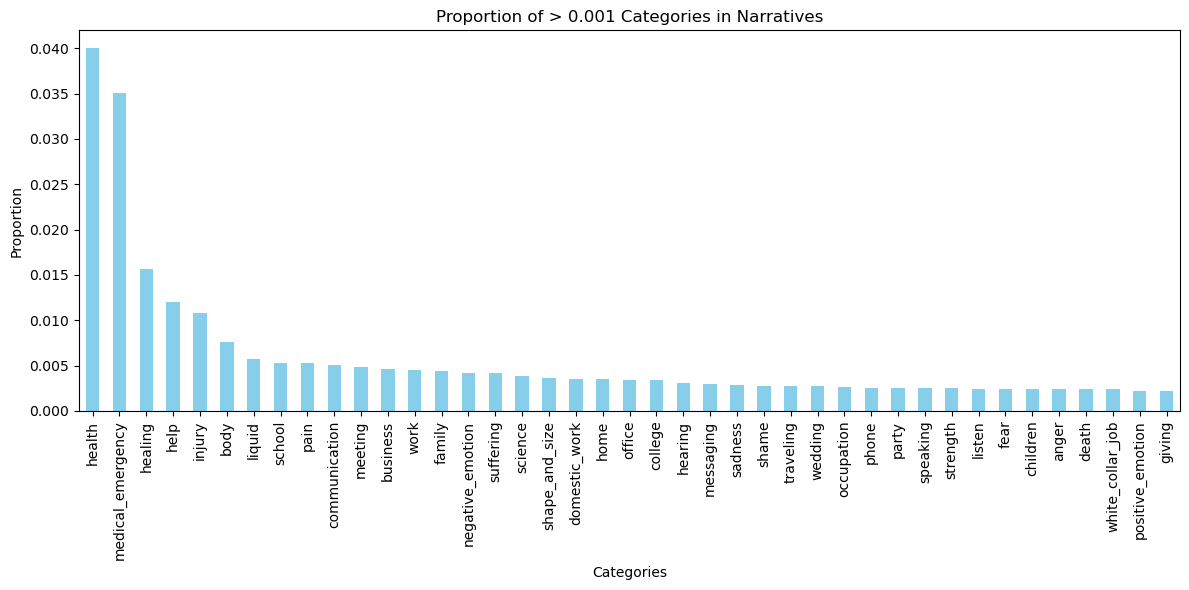

In [19]:


category_proportions = category_df_recommendations.mean()
print(f"category_proportions: {category_proportions}")
filtered_categories = category_proportions[category_proportions > 0.002]

# Plot the histogram
plt.figure(figsize=(12, 6))
filtered_categories.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Proportion of > 0.001 Categories in Narratives')
plt.xlabel('Categories')
plt.ylabel('Proportion')
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()